In [1]:
import matplotlib.pyplot as plt
from Objects.Simulation import Simulation
import numpy as np
%pylab
%matplotlib inline

from matplotlib import lines, markers
from cycler import cycler



Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Create cycler object. Use any styling from above you please
monochromeWithMarker = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':', '-.']) * cycler('marker', [ '.' ,'^']))
monochromeNoMarker = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':', '-.']) * cycler('marker', [',']))
monochrome = monochromeNoMarker.concat(monochromeWithMarker)
# Print examples of output from cycler object. 
# A cycler object, when called, returns a `iter.cycle` object that iterates over items indefinitely
print("number of items in monochrome:", len(monochrome))
# Overriding styles for current script
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.prop_cycle'] = monochrome
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['figure.figsize'] = (12,5)
mpl.rcParams['figure.dpi']= 300
MARKEREVERY = 50

number of items in monochrome: 12


In [3]:
def plot_one_key(x_timeline, ydata, key, keys):
    if len(keys) <=5:
        plt.plot(x_timeline, ydata , label = str(key+1), markevery=MARKEREVERY)
    else:
        plt.plot(x_timeline, ydata,marker='', color='black', markevery=MARKEREVERY)

In [23]:
def plot_one_record(record_zipped, dimension, x_timeline,title, startend = [],  legend=True):
    keys = record_zipped.keys()
    if startend:
        start_filter = ((x_timeline >= startend[0]) & (x_timeline <= startend[1]))
        x_timeline = x_timeline[start_filter]
    else:
        start_filter = np.full(x_timeline.shape ,True, dtype=bool) 
    for key in keys:
        ydata = record_zipped[key][dimension]
        ydata = ydata[start_filter]
        plot_one_key(x_timeline, ydata, key ,keys)
    if legend:
        plt.legend(title="Vehicle Sequence in Queue")
    ylabelmap = {
        0:r"acceleration - " + r"$\alpha(m/s^{2})$",
        1:r"speed - " + r"$\nu  (m/s)$",
        2:r"distance to the stop line - " + "$\chi(meter)$",
        3:r"headway - H(second)"
    }
    ylabel = ylabelmap[dimension]
    plt.ylabel(ylabel)
    plt.xlabel("Time (second)")
    plt.title(title)

In [5]:
def zip_records(records):
    record_zipped = {}
    for key in records.keys():
        record_zipped[key] = np.array(list(zip(*records[key].values())))
    return record_zipped

In [28]:
def plot_records(p, startend= []):
    records = p.records
    x_timeline = np.array(list(records[0].keys()))
    x_timeline = x_timeline / 1000
    record_zipped = zip_records(records)
    plot_one_record(record_zipped, 0, x_timeline, startend = startend)
    plt.show()
    plot_one_record(record_zipped, 1, x_timeline, startend = startend)
    plt.show()
    plot_one_record(record_zipped, 2, x_timeline, startend = startend)
    plt.show()
    plot_one_record(record_zipped, 3, x_timeline, startend = startend)
    plt.show()

def plot_two_subplots(p1,p2, startend=[], filename = None):
    r1 = p1[0].records
    r2 = p2[0].records
    xt1 = np.array(list(r1[0].keys()))/1000
    xt2 = np.array(list(r2[0].keys()))/1000
    rz1 = zip_records(r1)
    rz2 = zip_records(r2)
    plt.subplot(121)
    plot_one_record(rz1, p1[1], xt1, startend = startend, title = "(a)", legend=False)
    plt.subplot(122)
    plot_one_record(rz2, p2[1], xt2, startend = startend, title = "(b)", legend=False)
    keys = rz1.keys()
    if len(keys) <=5:
        plt.legend(title="Vehicle Sequence in Queue")
    if filename:
        plt.savefig('./pics/' + filename + '.png', dpi = 300)
    plt.show()

def plot_three_subplots(p1,p2,p3, startend=[], filename = None):
    r1 = p1[0].records
    r2 = p2[0].records
    r3 = p3[0].records
    xt1 = np.array(list(r1[0].keys()))/1000
    xt2 = np.array(list(r2[0].keys()))/1000
    xt3 = np.array(list(r3[0].keys()))/1000
    rz1 = zip_records(r1)
    rz2 = zip_records(r2)
    rz3 = zip_records(r3)
    plt.subplot(131)
    plot_one_record(rz1, p1[1], xt1,  legend=False)
    plt.subplot(132)
    plot_one_record(rz2, p2[1], xt2, legend=False)
    plt.subplot(133)
    plot_one_record(rz3, p3[1], xt3, startend, legend=False)
    keys = rz1.keys()
    if len(keys) <=5:
        plt.legend(title="Vehicle Sequence in Queue")
    if filename:
        plt.savefig('./pics/' + filename + '.png', dpi = 300)
    plt.show()

In [7]:
def cal_one_p(p):
    return np.mean(p.delays), np.max(p.delays), p.vehPass

def cal_vdr(ps, tg):
    if type(ps) is not list:
        ps = [ps]
    total_vehPass = 0
    total_tg = 0
    for p in ps:
        total_vehPass += p.vehPass
        total_tg += tg
    return total_vehPass / total_tg * 3600

In [8]:
def map_platoon_hpass0(p):
    return list(map(lambda car: car.headway_pass_zero,p.platoon))

In [34]:
simulation_time = 100 # seconds
n = 5 # number of vehicles
intended_speed = 80 * 1000/3600 # intended speed / speed limit of the road
sim = Simulation(time = simulation_time, avStep = 100)


LRT = [1.4, -1.4]
HSR = [0.5, -0.5]

human_profile = [1.7, -2.0]
av_profile = HSR
HUMAN_T = 1.8

paras={
    'v_intend': intended_speed,
    'human_max_acc': human_profile[0],
    'human_max_dec': human_profile[1],
    'max_acc': av_profile[0],
    'max_dec': av_profile[1],
    'tsys': 1.0,
    'human_T': HUMAN_T,
    'AV_T': 1.6
}


cav = sim.run_cav_simulation(n, paras)

av = sim.run_av_simulation(n, paras)

human = sim.run_human_simulation(n, paras) 



In [10]:
# print("Average delay is {}, the highest delay is {}, vehicle pass number is {}, VDR is {}".format(*cal_one_p(av), cal_vdr(av, simulation_time)))
# print("Average delay is {}, the highest delay is {}, vehicle pass number is {}, VDR is {}".format(*cal_one_p(cav), cal_vdr(cav, simulation_time)))
print("Average delay is {}, the highest delay is {}, vehicle pass number is {}, VDR is {}".format(*cal_one_p(human), cal_vdr(human, simulation_time)))

Average delay is 3.4316315408027505, the highest delay is 5.4099876277249965, vehicle pass number is 5, VDR is 180.0


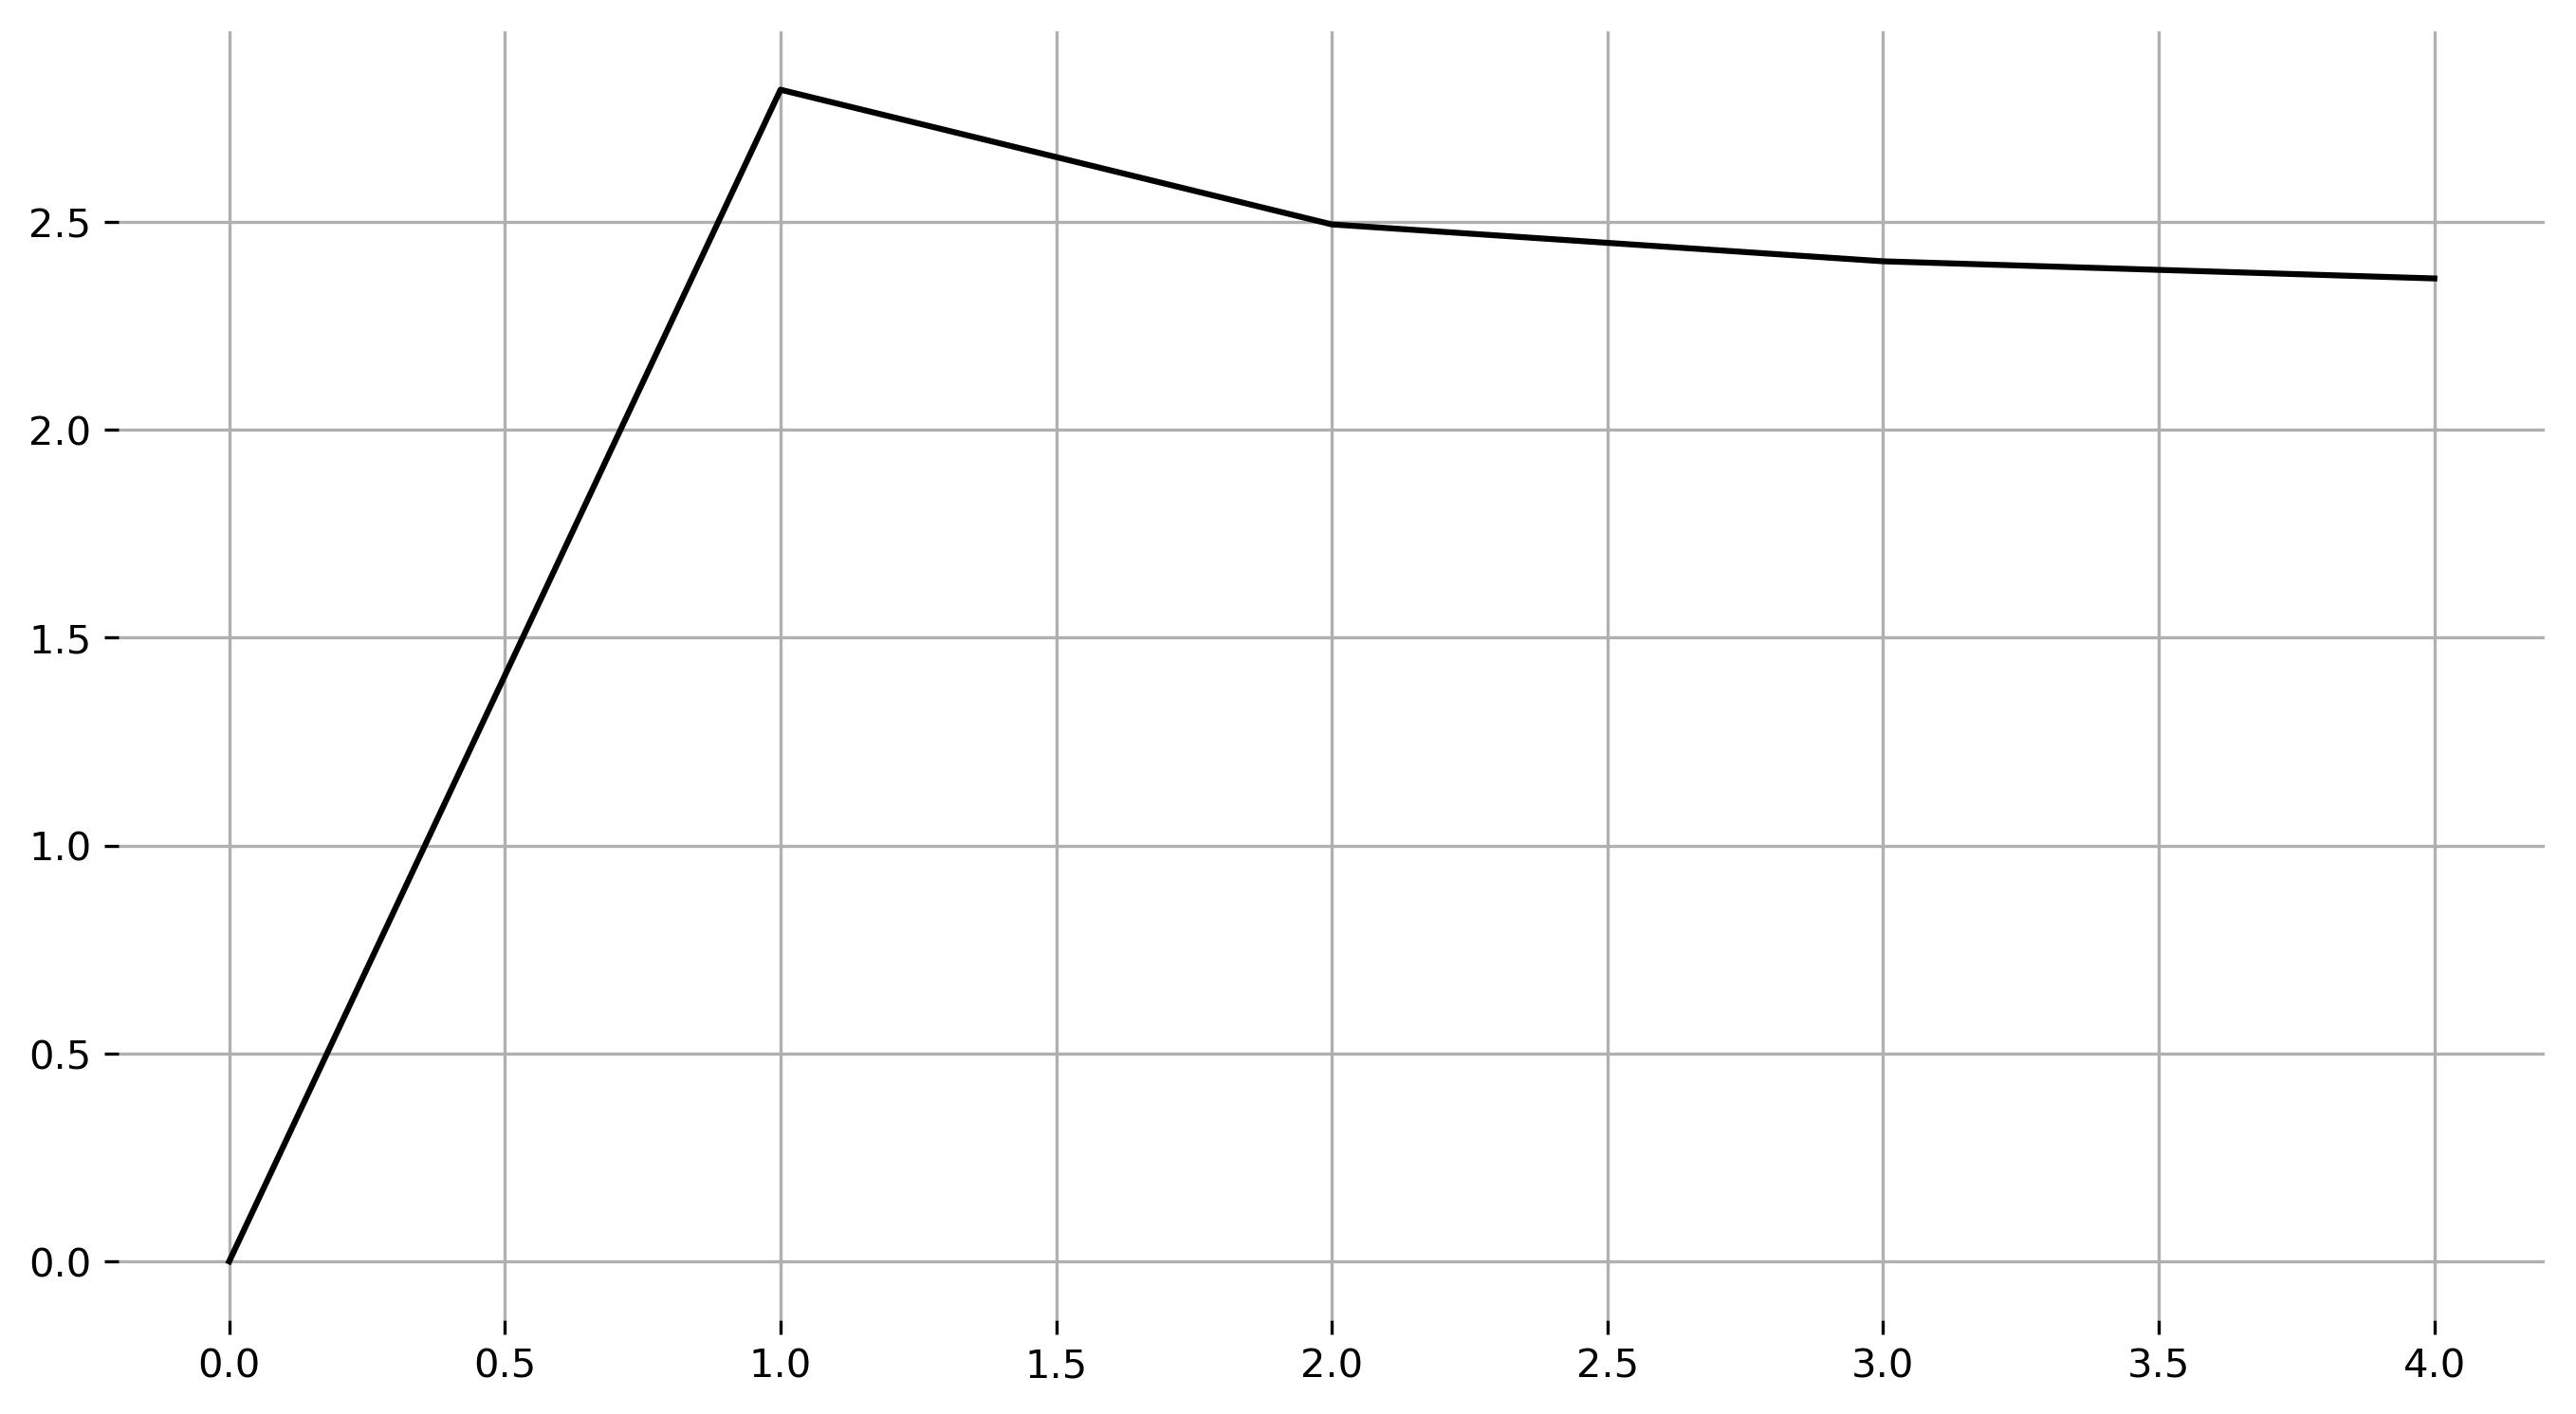

In [18]:

plt.plot(map_platoon_hpass0(human))

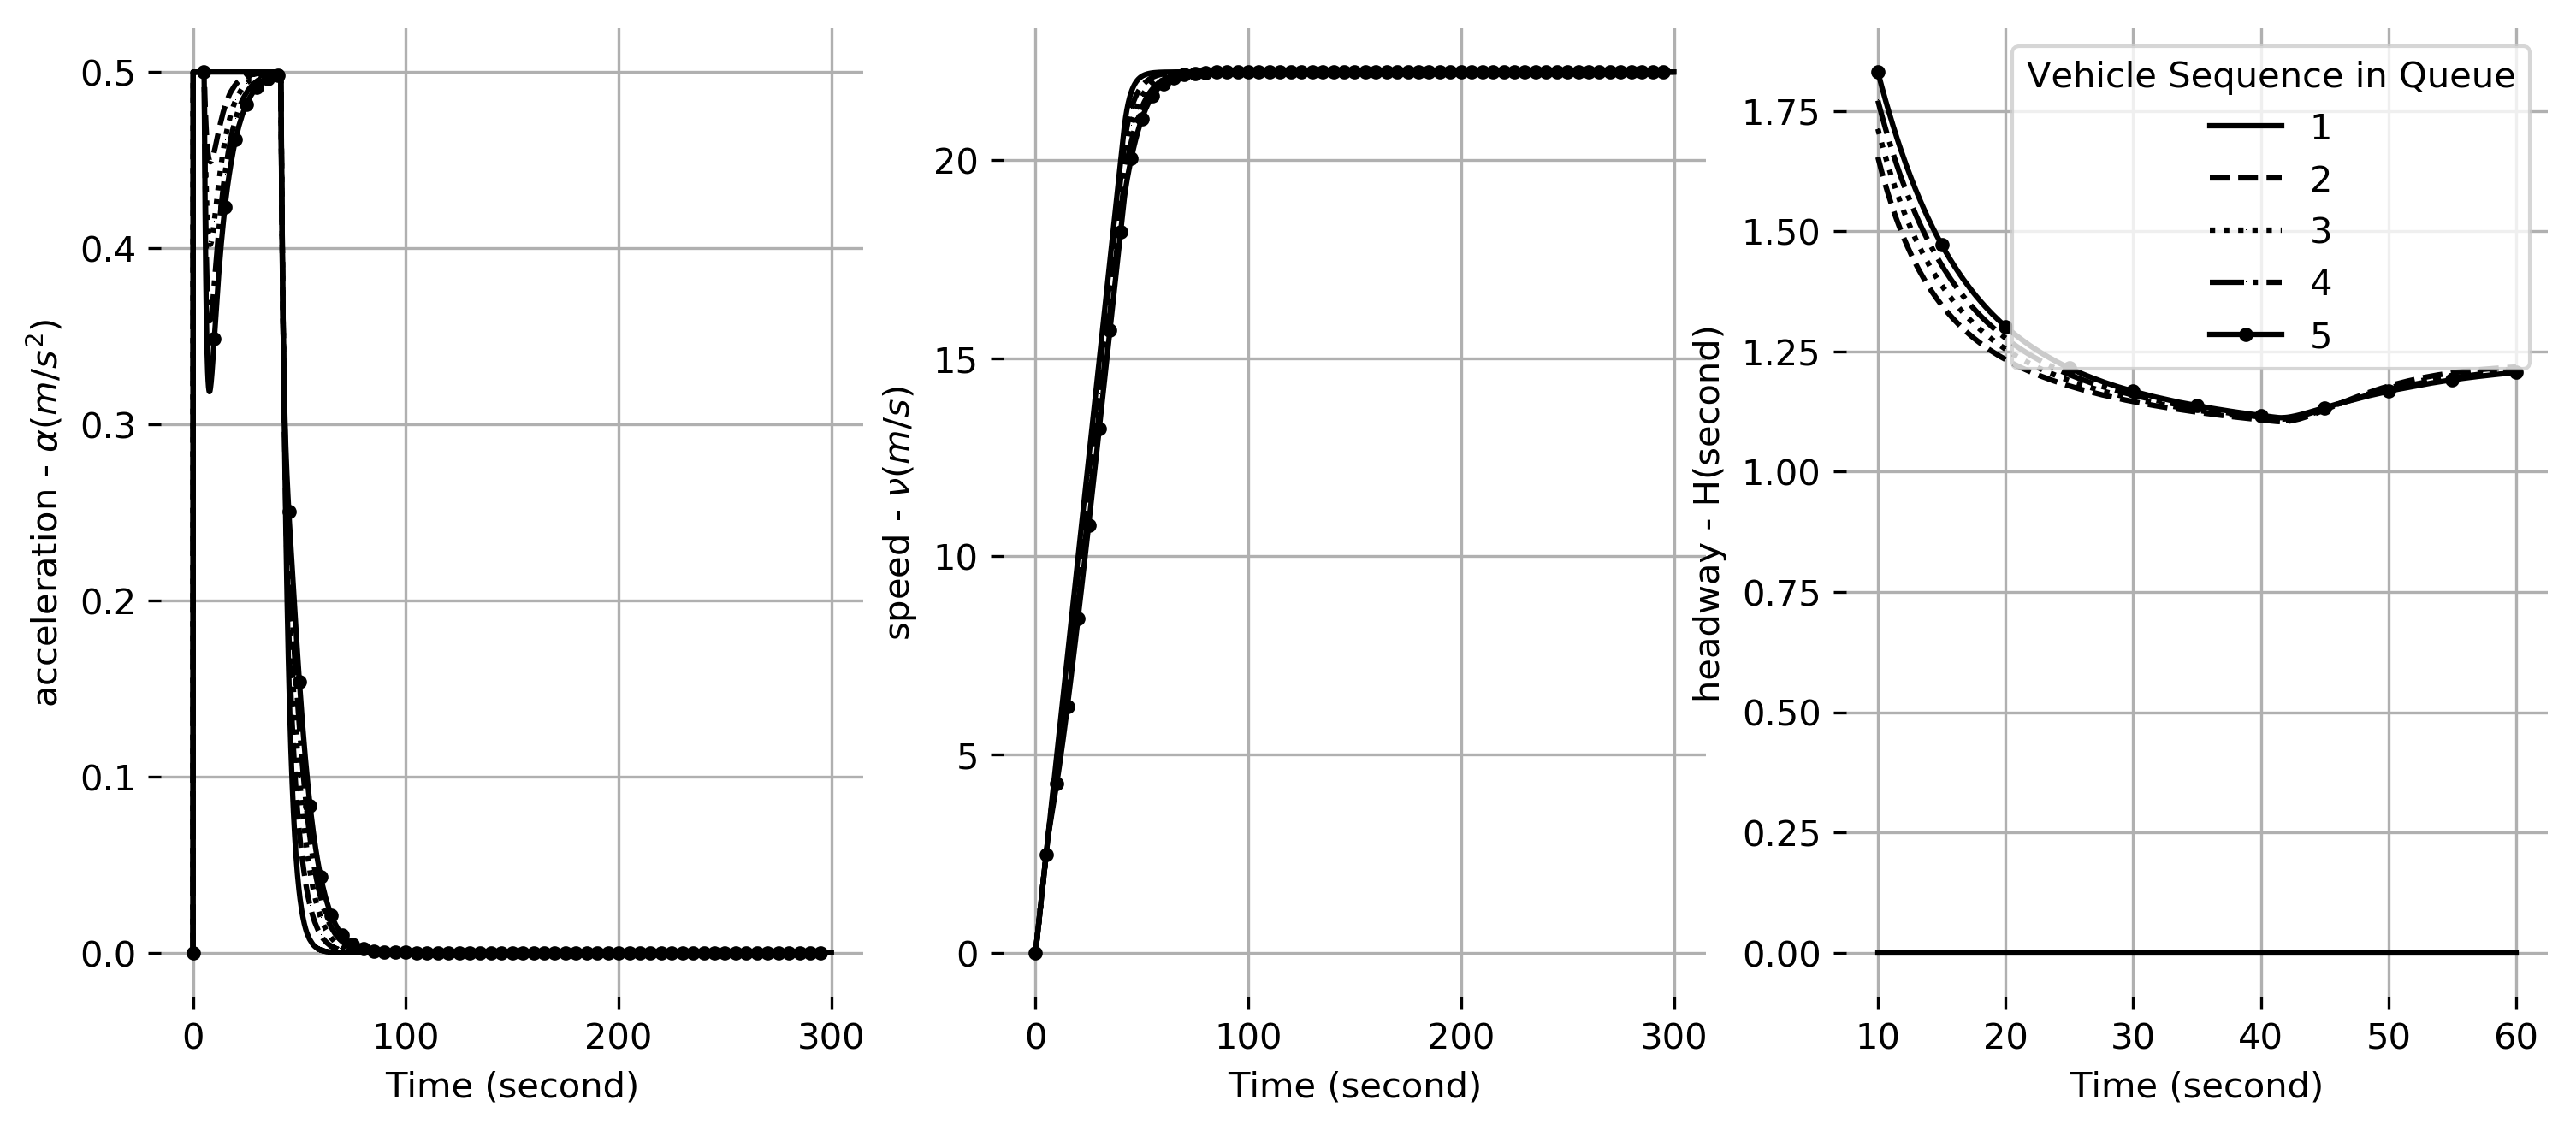

In [12]:
plot_three_subplots([cav, 0], [cav, 1], [cav, 3],startend=[10,60])

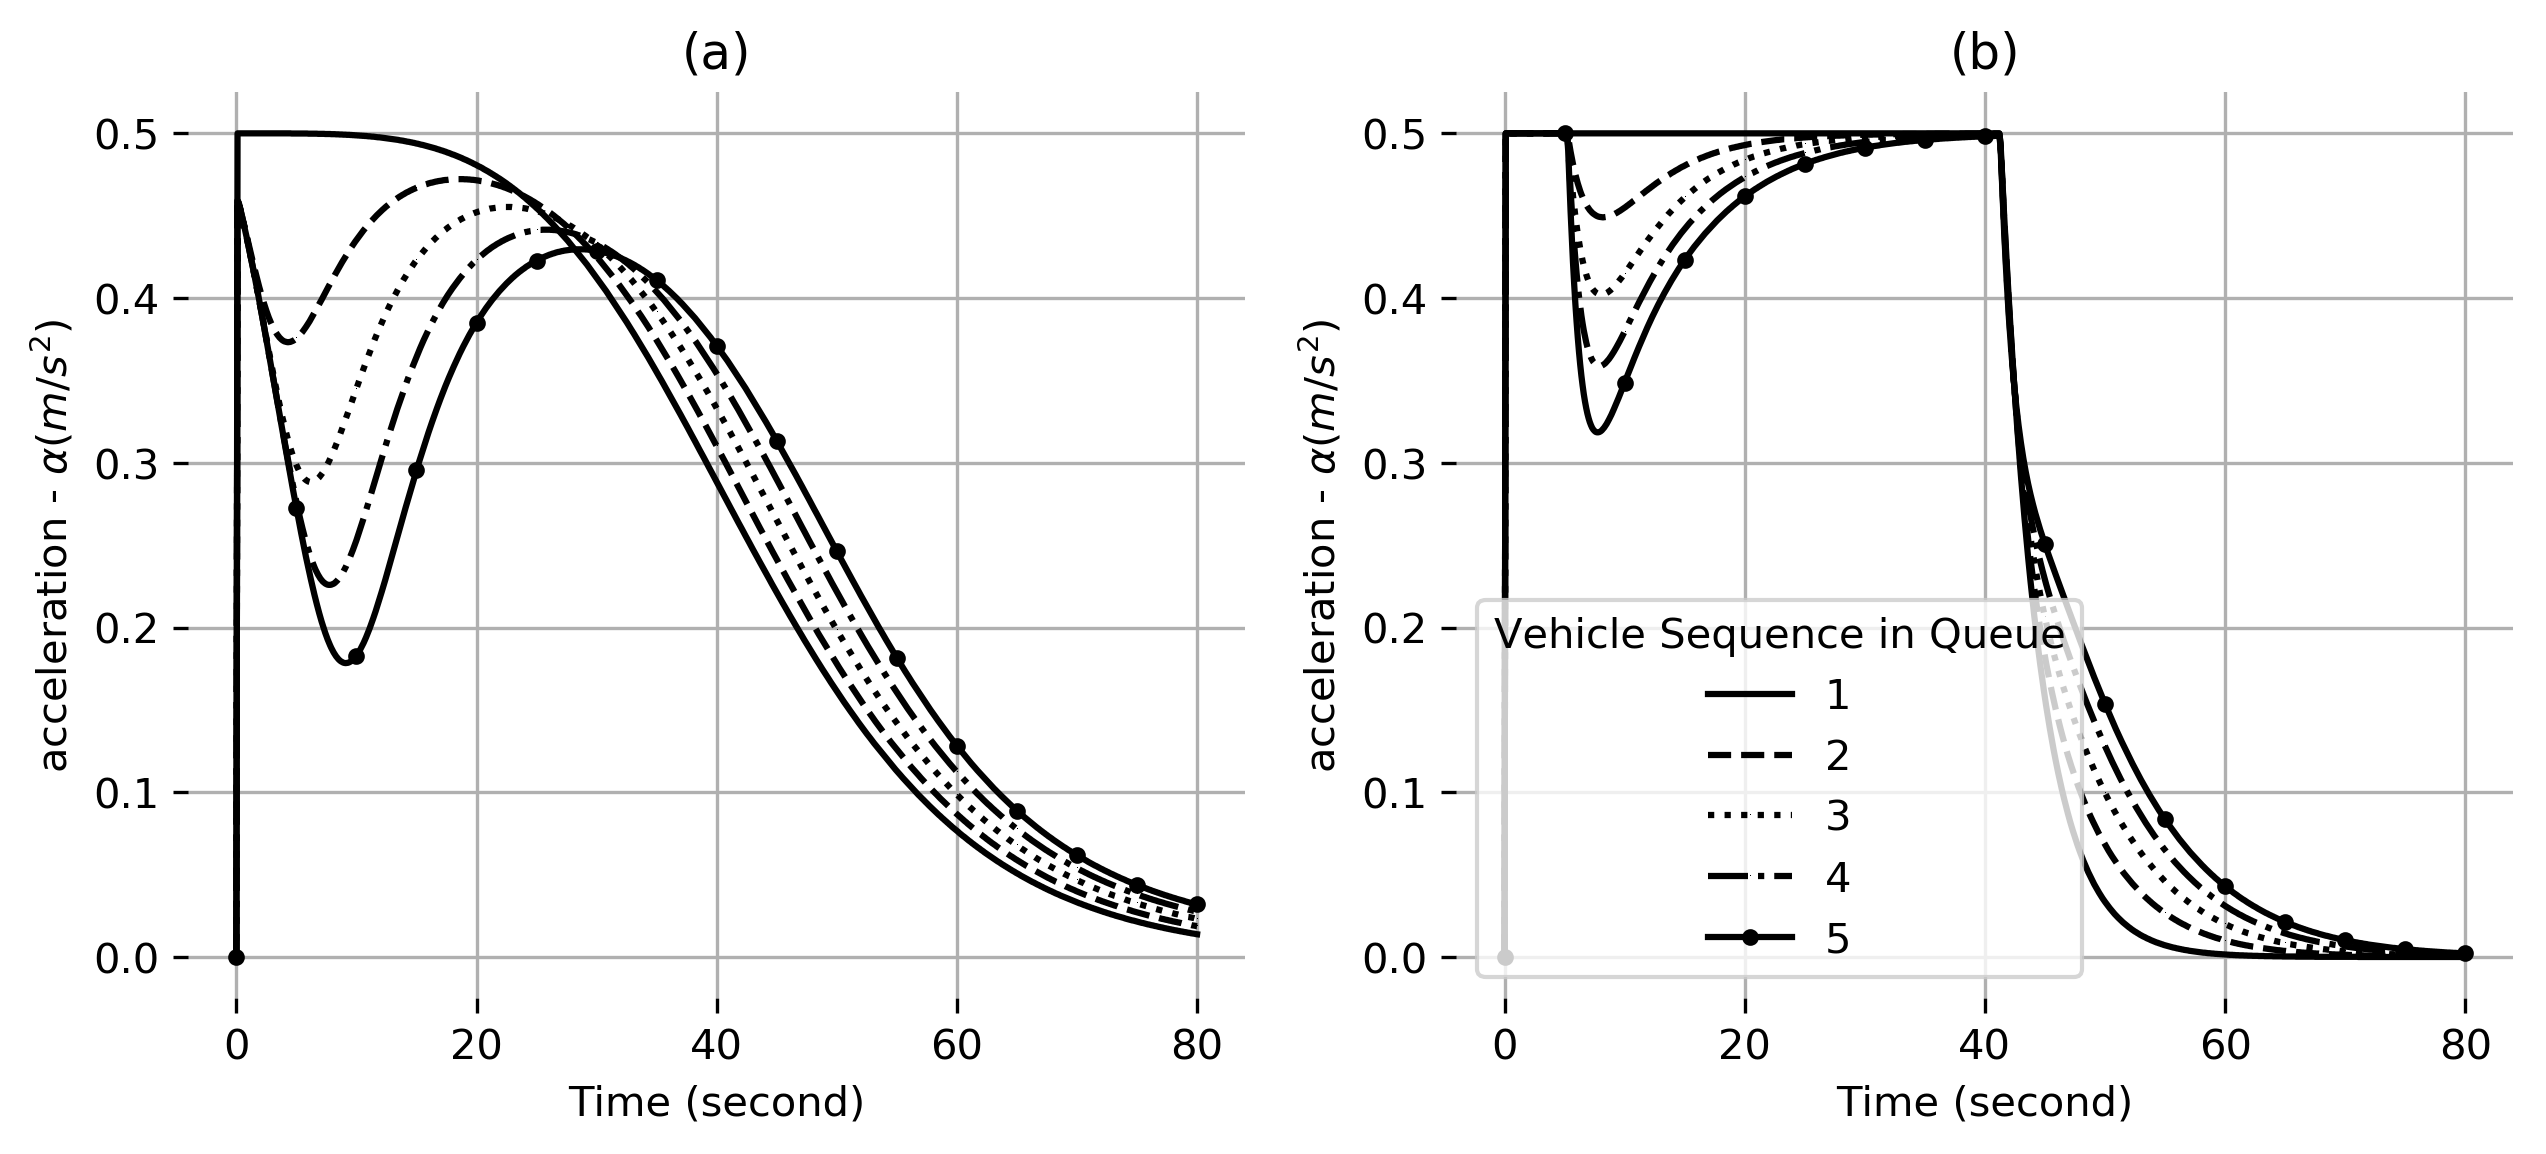

In [35]:
dim = 0
plt.figure(figsize=(10,4))
plot_two_subplots([av, dim], [cav, dim], startend = [0,80])

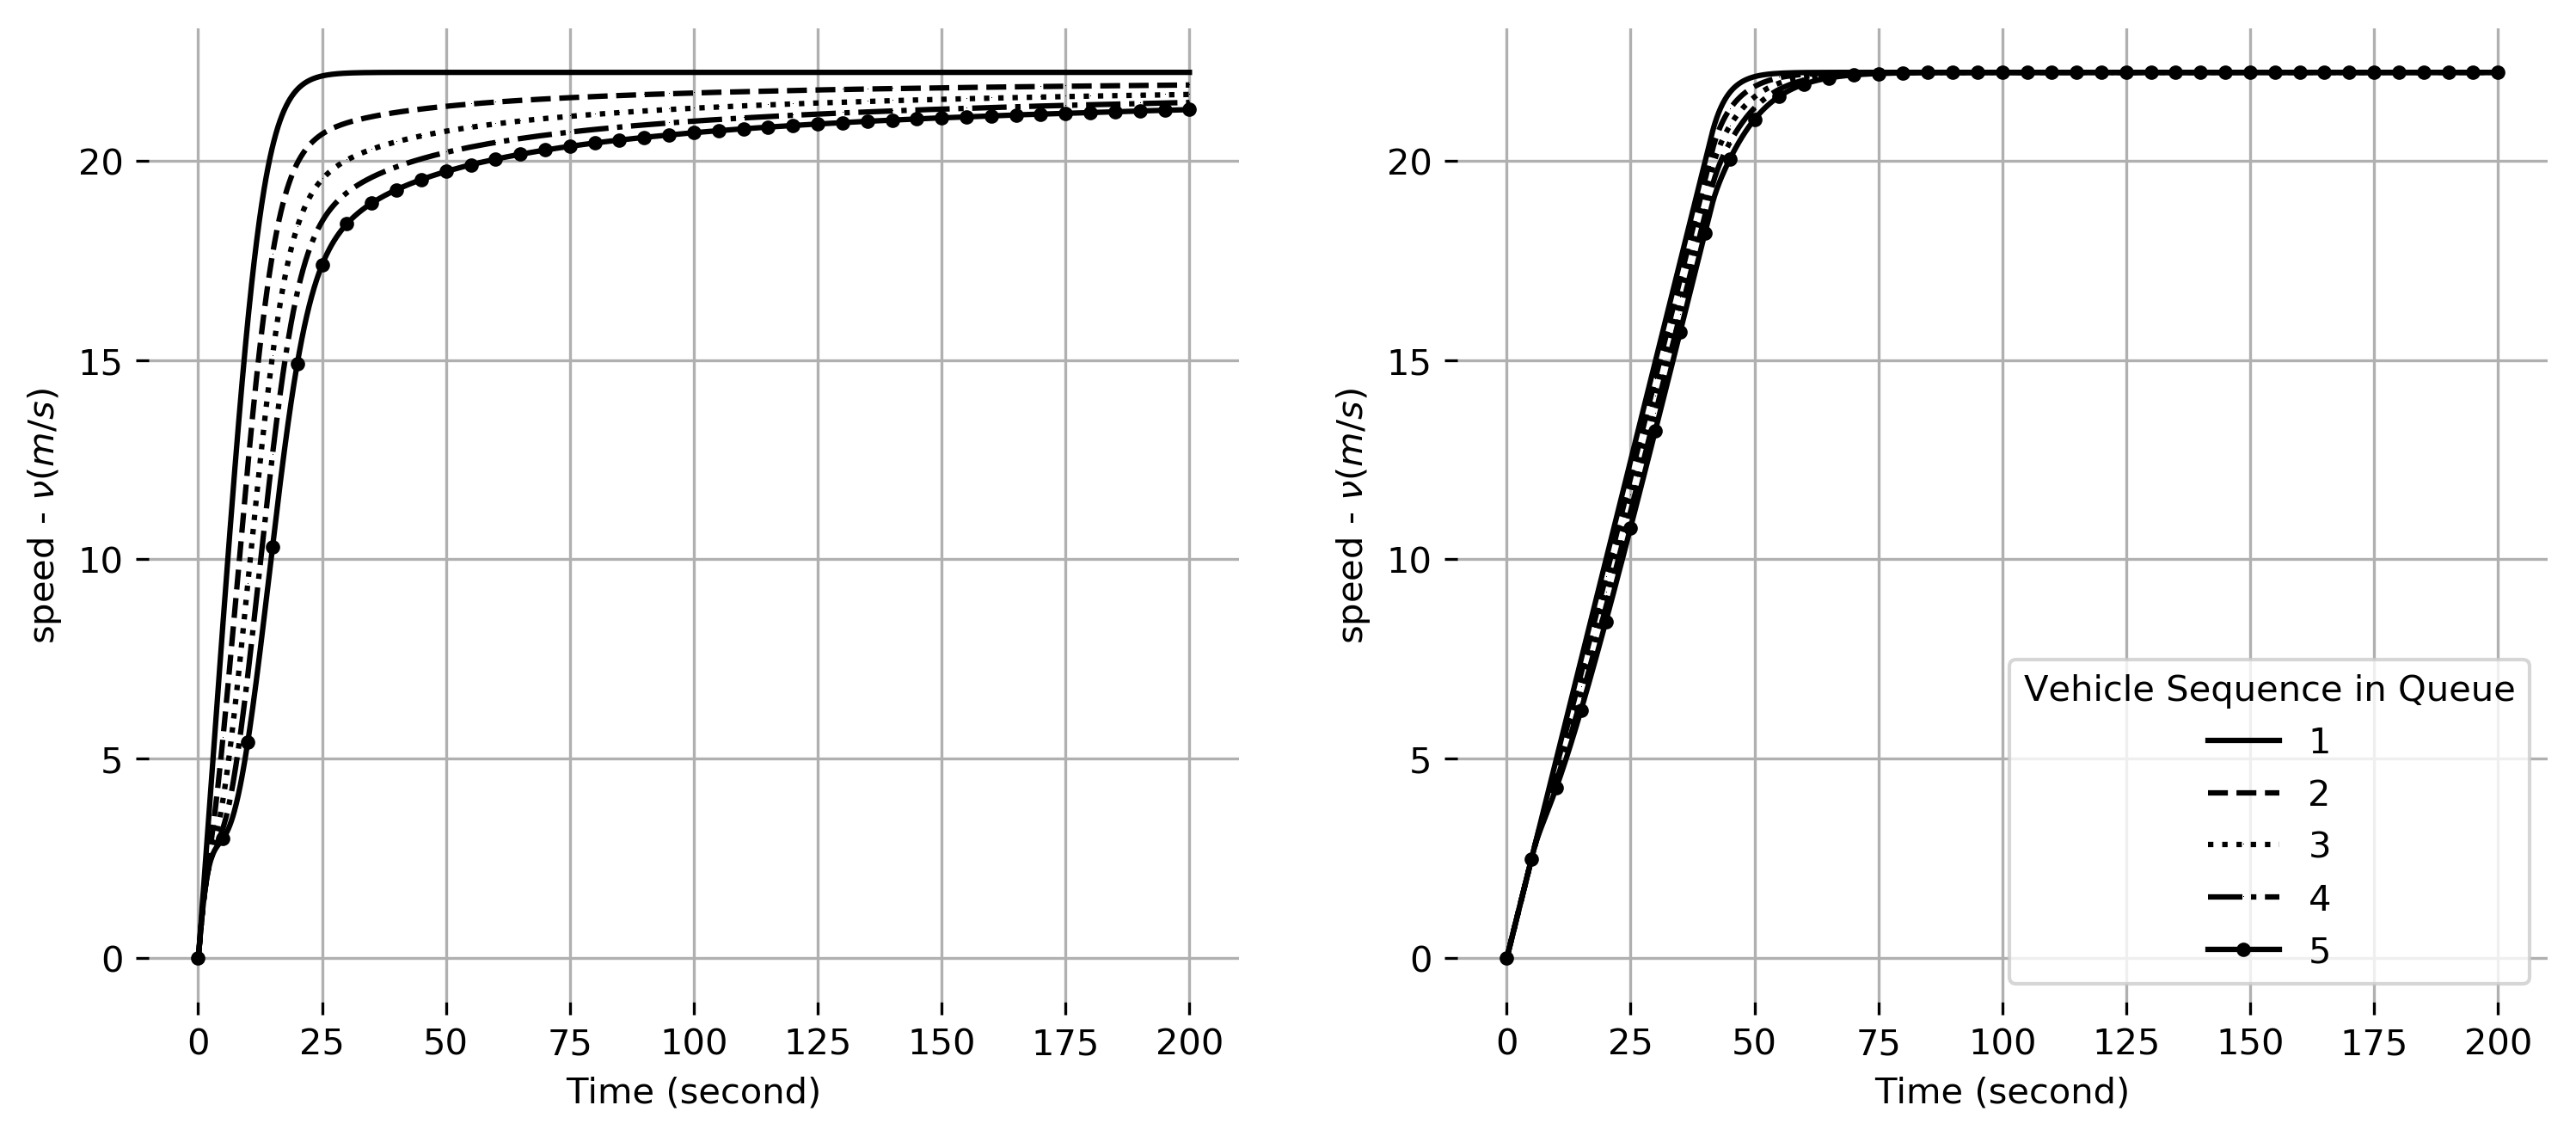

In [14]:
dim = 1
plot_two_subplots([human,dim], [cav, dim], startend = [0,200])

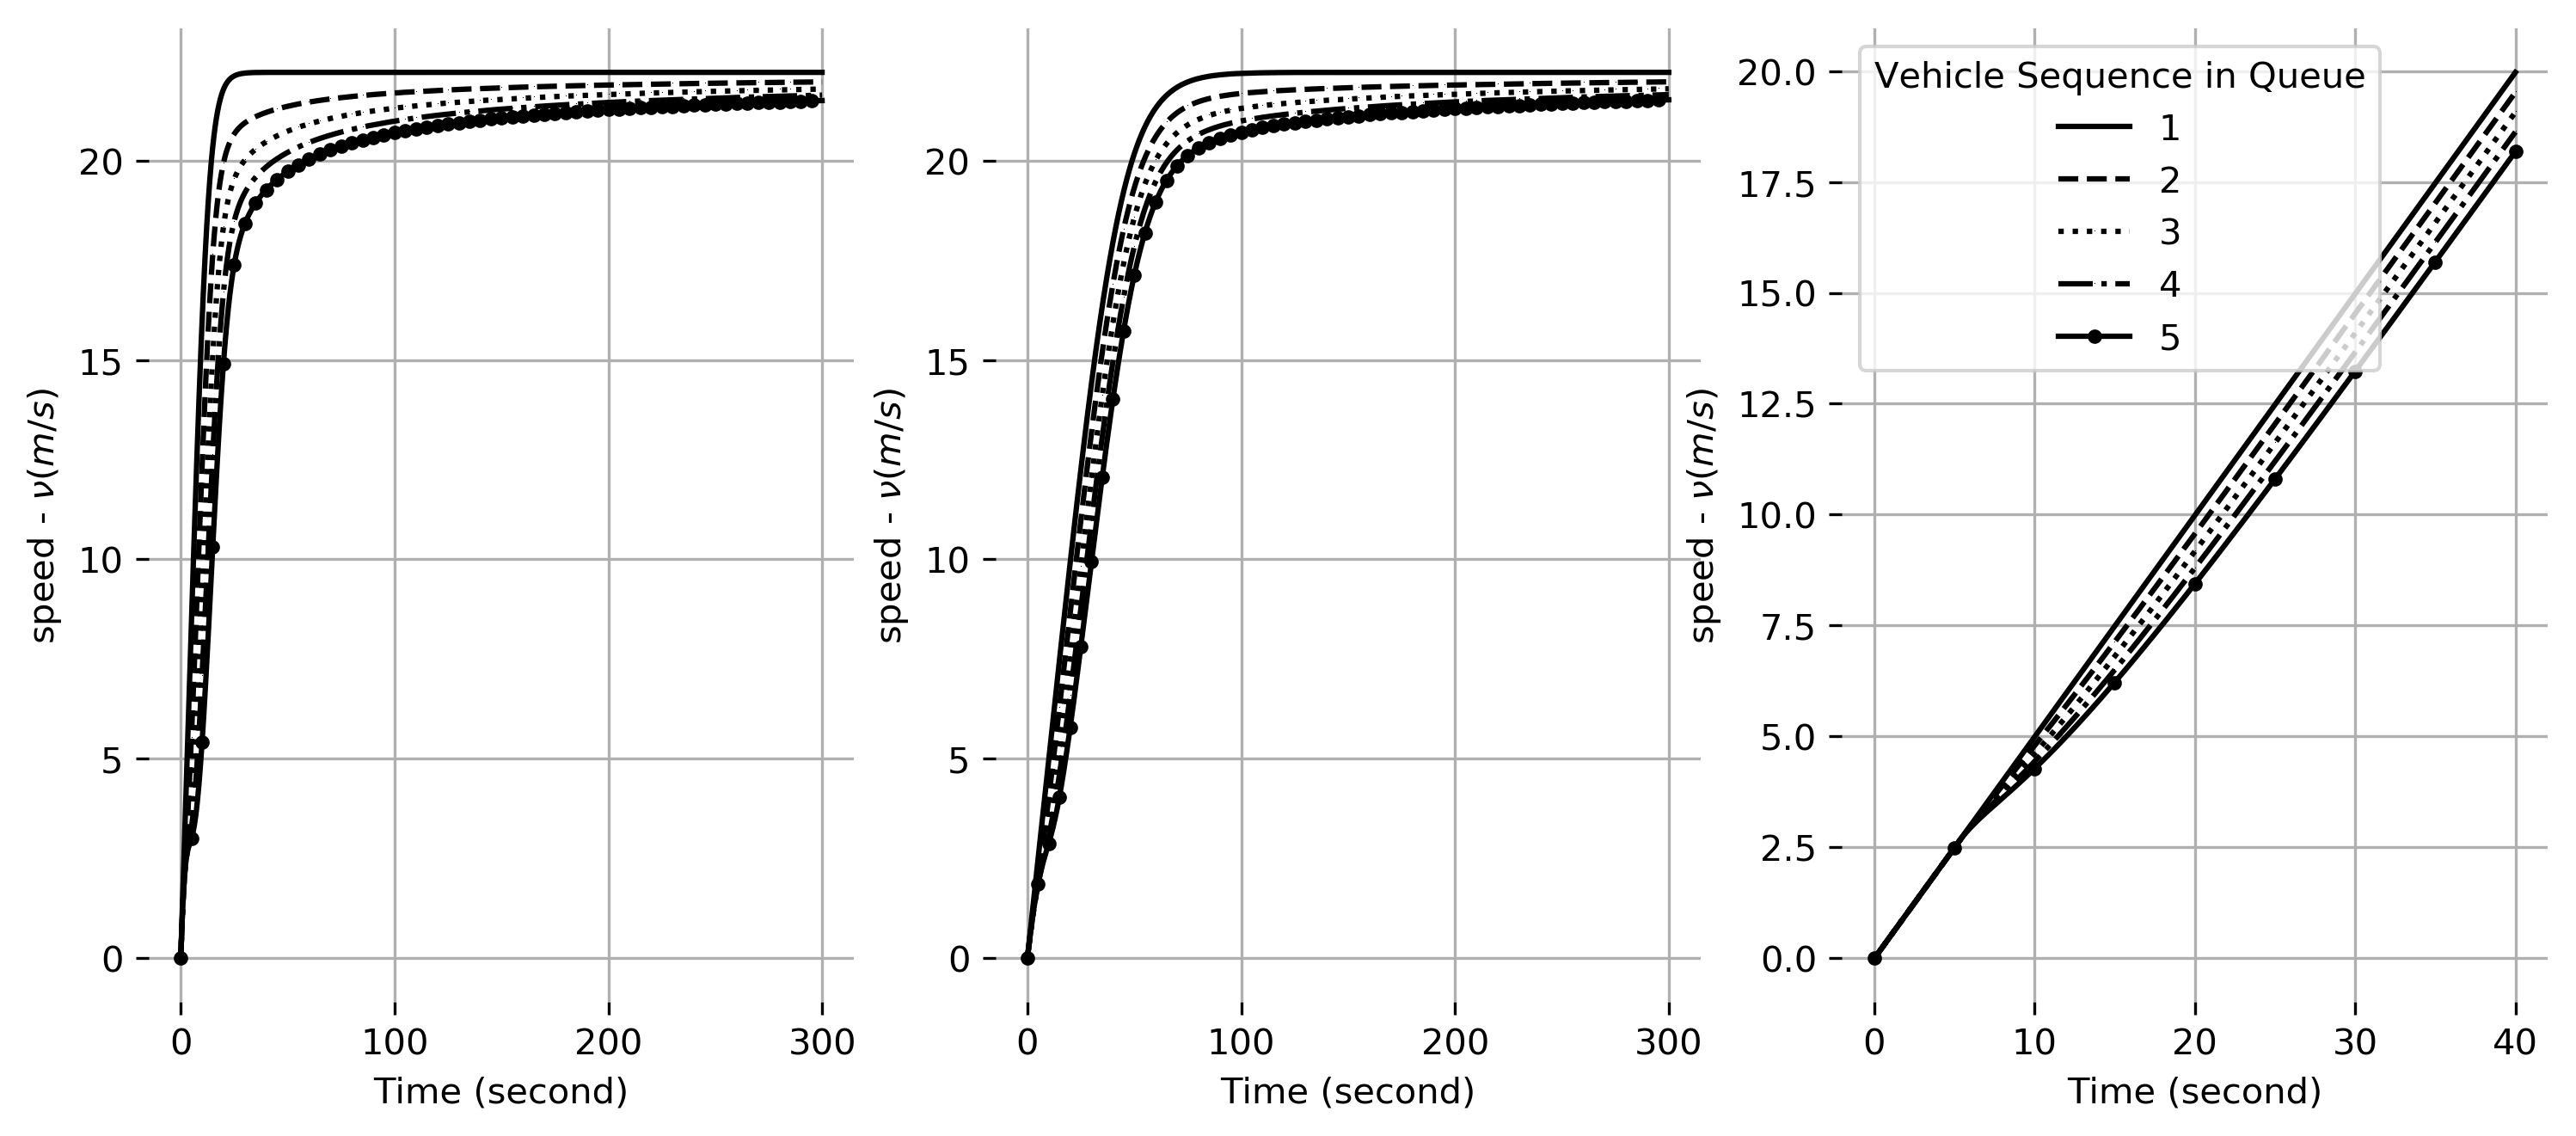

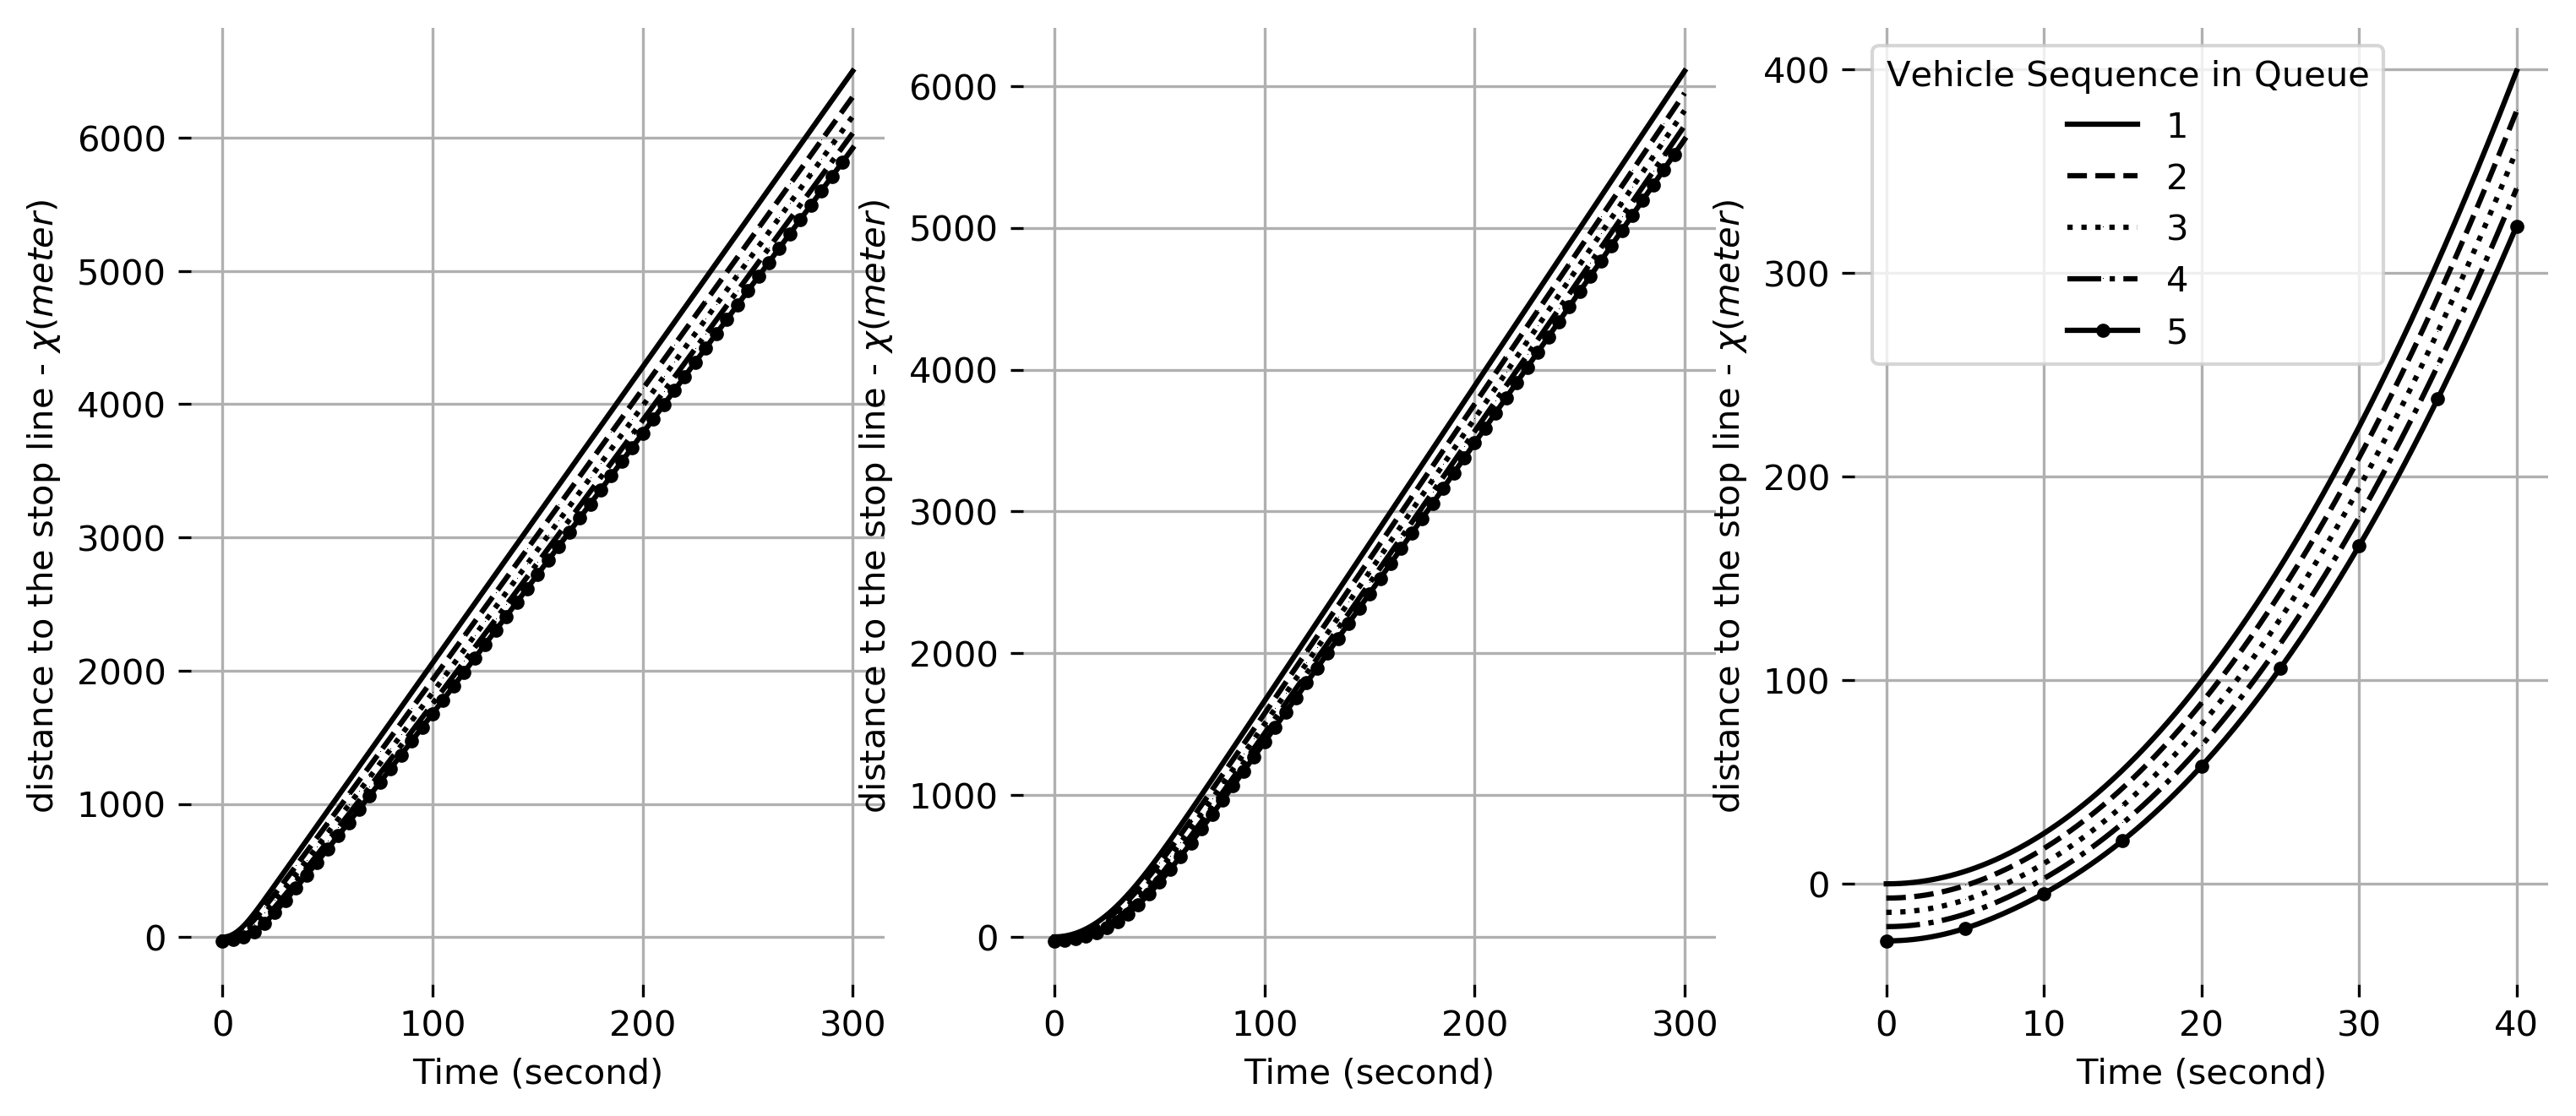

In [15]:
dim = 1
plot_three_subplots([human, dim], [av, dim], [cav, dim],startend=[0,40])
dim = 2
plot_three_subplots([human, dim], [av, dim], [cav, dim],startend=[0,40])

In [16]:
simulation_time = 60 # seconds
n = 100 # number of vehicles
intended_speed = 80 * 1000/3600 # intended speed / speed limit of the road
sim = Simulation(time = simulation_time, avStep = 100)


LRT = [1.34, -1.34]
HSR = [0.58, -0.54]

human_profile = [1.7, -2.0]
av_profile = LRT
HUMAN_T = 1.80

paras={
    'v_intend': intended_speed,
    'human_max_acc': human_profile[0],
    'human_max_dec': human_profile[1],
    'max_acc': av_profile[0],
    'max_dec': av_profile[1],
    'tsys': 0.8,
    'human_T': HUMAN_T,
    'AV_T': 1.2
}


cav1 = sim.run_cav_simulation(n, paras)

av1 = sim.run_av_simulation(n, paras)

human1 = sim.run_human_simulation(n, paras)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 600 but corresponding boolean dimension is 1800

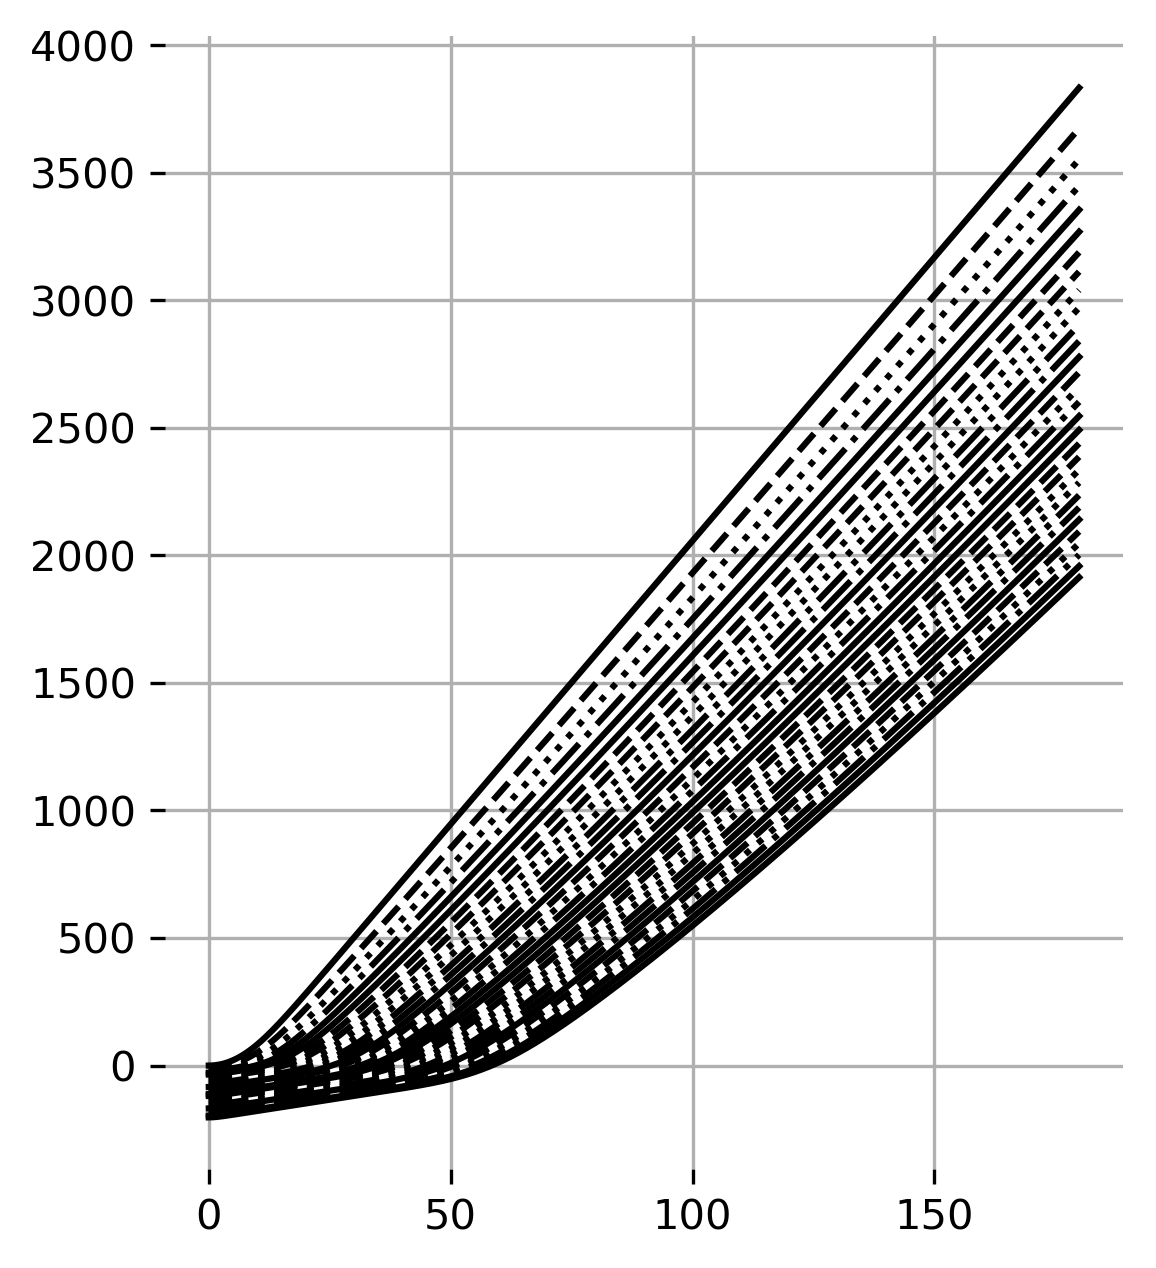

In [17]:
dim = 2
plt.figure(figsize=(14,5))
plot_three_subplots([human1, dim], [av1, dim], [cav1, dim],startend=[0,999])
print("Average delay is {}, the highest delay is {}, vehicle pass number is {}, VDR is {}".format(*cal_one_p(av1), cal_vdr(av1, simulation_time)))
print("Average delay is {}, the highest delay is {}, vehicle pass number is {}, VDR is {}".format(*cal_one_p(cav1), cal_vdr(cav1, simulation_time)))
print("Average delay is {}, the highest delay is {}, vehicle pass number is {}, VDR is {}".format(*cal_one_p(human1), cal_vdr(human1, simulation_time)))

In [ ]:
av1.delays